In [262]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import boxcox
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [263]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [264]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()


def ma_predict(series, n, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-n:].mean()]), ignore_index=True)
    return new_series


# given a series and alpha, return series of smoothed points
def double_exponential_smoothing(series, alpha, beta, n_preds):
    result = [series[0]]
    for n in range(1, len(series) + n_preds):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # we are forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend
                                                                  )
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i + slen] - series[i]) / slen
    return sum / slen


def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series) + n_preds):
        if i == 0:  # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):  # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m * trend) + seasonals[i % slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha * (val - seasonals[i % slen]) + (1 - alpha) * (smooth + trend)
            trend = beta * (smooth - last_smooth) + (1 - beta) * trend
            seasonals[i % slen] = gamma * (val - smooth) + (1 - gamma) * seasonals[i % slen]
            result.append(smooth + trend + seasonals[i % slen])
    return result

def mse_dema(X):
    alpha, beta, gamma = X
    result = double_exponential_smoothing(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

def mse_tema(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

def plot(series):
    plt.figure(figsize=(14, 8))
    for k, v in series.items():
        plt.plot(v, label=k)
    plt.legend(loc=2)

In [265]:
series = airlines_passengers['Count']
train, test = series[:90], series[90:]
len(series)

144

C:\Users\never\AppData\Local\Temp\ipykernel_28524\1185700104.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_series = new_series.append(pd.Series([new_series[-n:].mean()]), ignore_index=True)


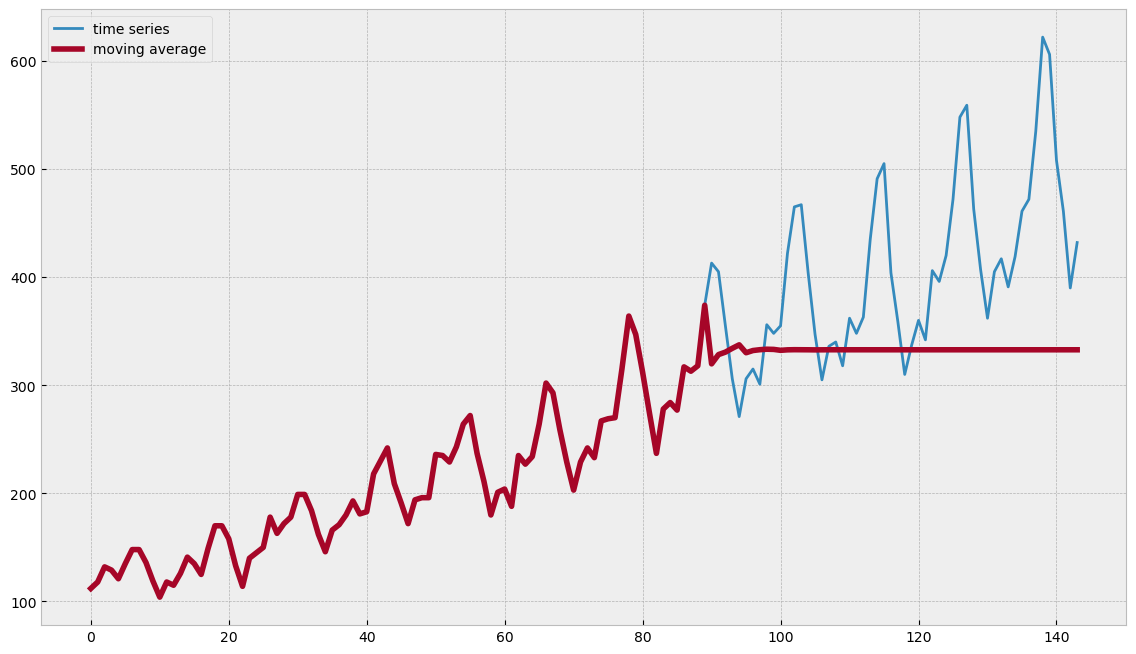

In [266]:
ma_ser = ma_predict(train, 5, len(series) - len(train))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, label='time series')
    plt.plot(ma_ser, linewidth='4', label='moving average')
    plt.legend()

In [267]:
def plot_tema(alpha, beta, gamma, X, series_to_plot=None, n_preds=24):
    if series_to_plot is None:
        series_to_plot = X

    tema = triple_exponential_smoothing(X, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series_to_plot, label='time series')
        plt.plot(tema, linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

def plot_dema(alpha, beta, X, series_to_plot, n_preds=24):
    if series_to_plot is None:
        series_to_plot = X

    dema = double_exponential_smoothing(X, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series_to_plot, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

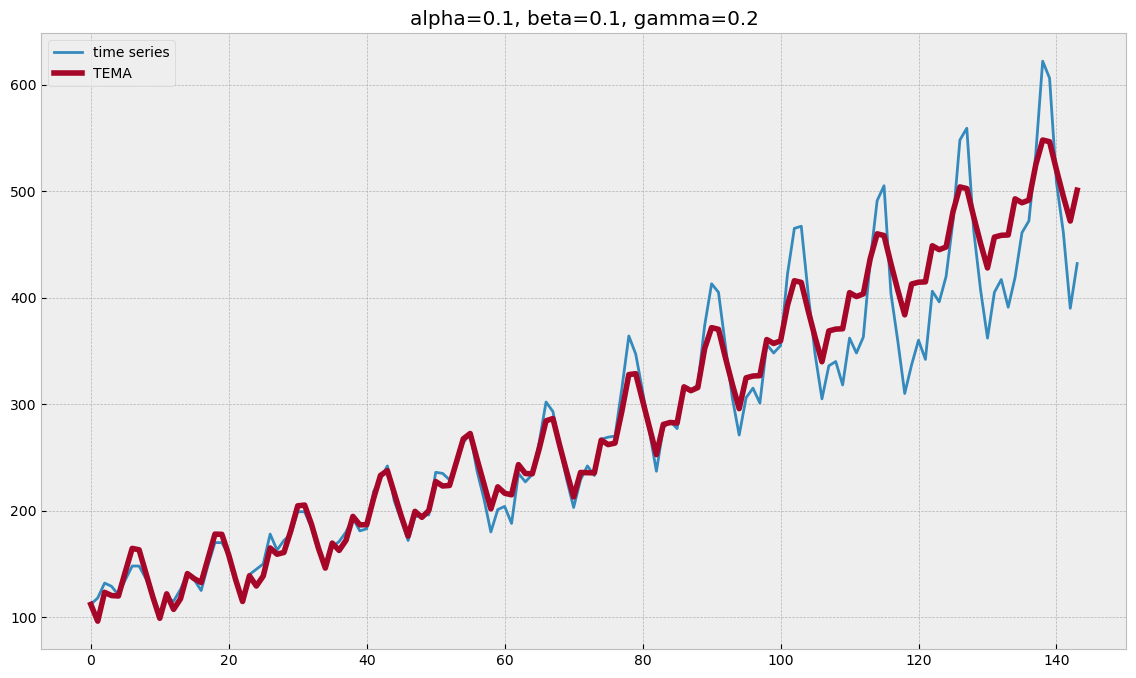

In [268]:
plot_tema(0.1, 0.1, 0.2, train, series, len(series) - len(train))

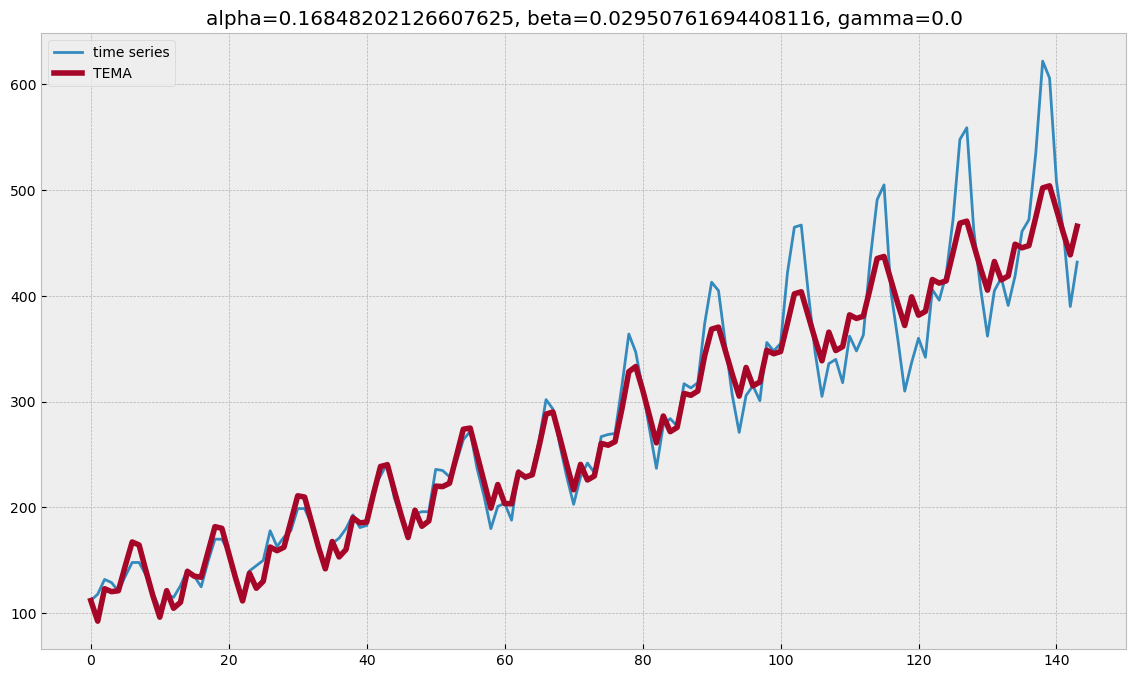

In [269]:
opt = minimize(mse_dema, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
plot_tema(alpha_opt, beta_opt, gamma_opt, train, series, len(series) - len(train))

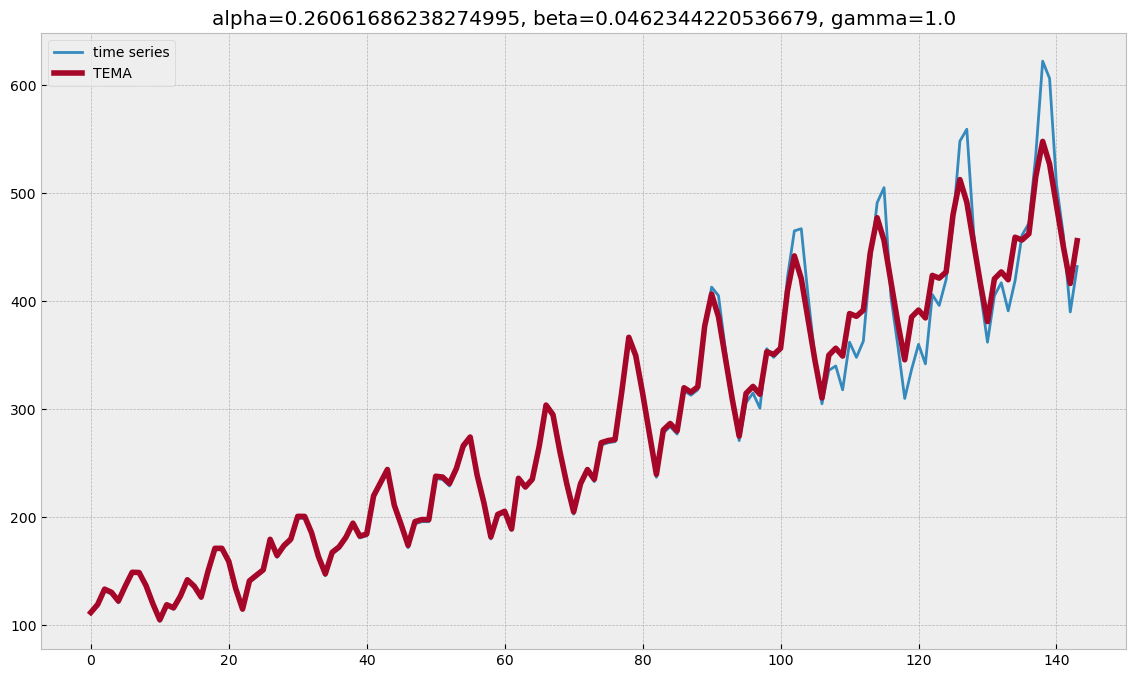

In [270]:
opt = minimize(mse_tema, x0=[0,0,0], method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
plot_tema(alpha_opt, beta_opt, gamma_opt, train, series, len(series) - len(train))

C:\Users\never\AppData\Local\Temp\ipykernel_28524\1185700104.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_series = new_series.append(pd.Series([new_series[-n:].mean()]), ignore_index=True)


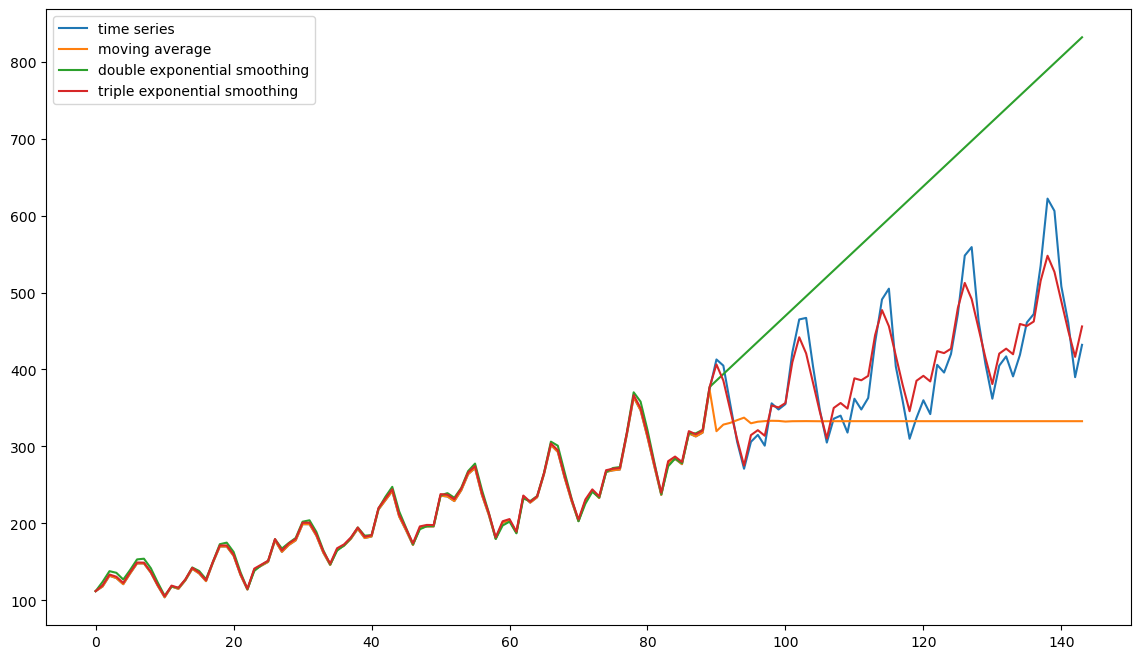

In [271]:
plot({
    'time series': series,
    'moving average': ma_predict(train, 5, len(series) - len(train)),
    'double exponential smoothing': double_exponential_smoothing(train, alpha=0.9, beta=0.1, n_preds=len(series) - len(train)),
    'triple exponential smoothing': triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(series) - len(train)),
})

### Сделаем ряд стационарным

In [272]:
series1 = boxcox(series.to_numpy(), 0)
series1 = series1[1:] - series1[:-1]
series1 = pd.Series(series1)
train1, test1 = series1[:90], series1[90:]

C:\Users\never\AppData\Local\Temp\ipykernel_28524\1185700104.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_series = new_series.append(pd.Series([new_series[-n:].mean()]), ignore_index=True)


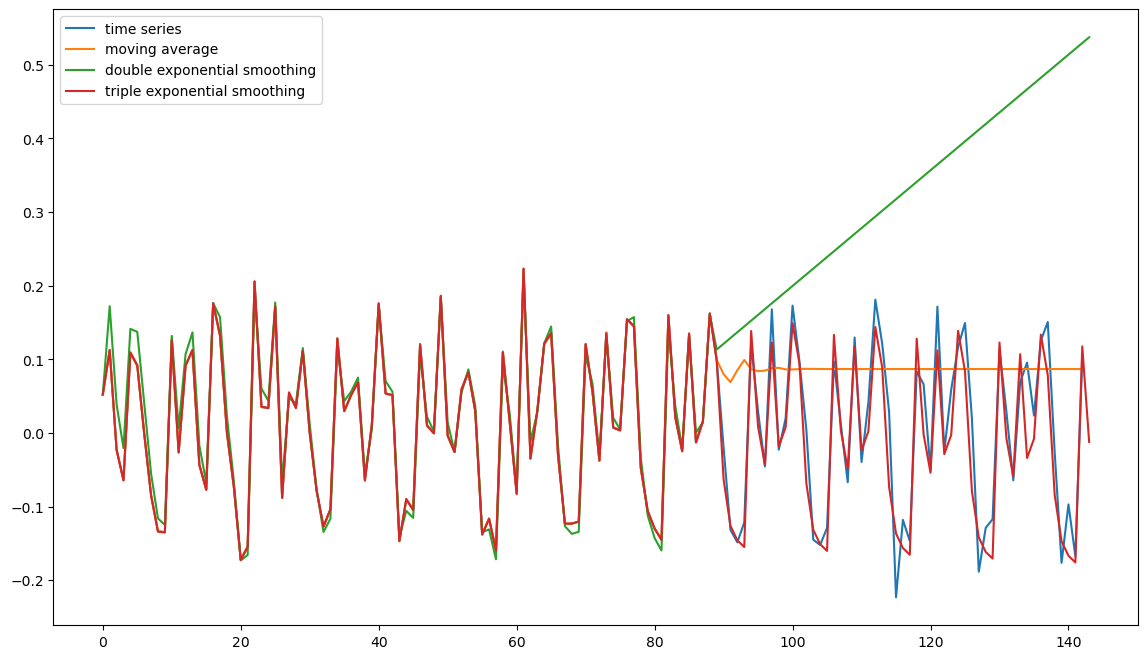

In [273]:
plot({
    'time series': series1,
    'moving average': ma_predict(train1, 5, len(series1) - len(train1)),
    'double exponential smoothing': double_exponential_smoothing(train1, alpha=0.9, beta=0.1, n_preds=len(series) - len(train)),
    'triple exponential smoothing': triple_exponential_smoothing(train1, 12, alpha_opt, beta_opt, gamma_opt, len(series) - len(train)),
})

### Вывод:
Метод Хольта-Винтерса отлично работает и на стационарном и на нестационарном ряду.
Но на нестационарном ряду он плохо предсказывает растущую дисперсию